# Consolidated Economic Analysis Notebook
**Deliverable:** Single notebook containing *all* project code, data exploration, cleaning, descriptive analytics, and econometric modelling.

**Generated:** 2025-05-09 15:54  

Run the notebook sequentially (**Kernel ▶ Run All**) to reproduce the full workflow without any external Python files.

## 1  Exploring data with visualisations

In [21]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure data directories exist (skip if absent in fresh environment)
for folder in ['data/raw', 'data/interim', 'data/processed']:
    if not os.path.exists(folder):
        os.makedirs(folder, exist_ok=True)

print('Raw files:', os.listdir('data/raw'))
print('Interim files:', os.listdir('data/interim'))
print('Processed files:', os.listdir('data/processed'))


Raw files: ['FAS.csv', 'GII.csv', 'WID.csv', 'WGI.csv', 'Instruments_FII.csv', 'WDI.csv', 'HDR25_Composite_indices_metadata.xlsx', 'Metadata']
Interim files: ['FI_index.csv', 'GII_cleaned.csv', 'Instruments_FII_lagged.csv', 'WID_cleaned.csv', 'WGI_cleaned.csv', 'FAS_cleaned.csv', 'WDI_cleaned.csv']
Processed files: []


In [22]:
import sys
from pathlib import Path

# Ensure project root is on PYTHONPATH so `import functions…` works
project_root = Path.cwd() / "functions"
project_root = project_root.resolve()
sys.path.insert(0, str(project_root))

from functions.data_cleaning import main  # Import the main function from data_cleaning.py
from functions.build_panel import build_panel  # Import the build_panel function from build_panel.py

# Clean raw data and save to data/processed/panel_2003_2023.csv
main()  # from data_cleaning.py

# Load data from panel_2003_2023.csv
panel_df = build_panel()

# Display the first few rows of the loaded data
panel_df.head()


Files found in data/raw directory:
  - FAS.csv
  - GII.csv
  - WID.csv
  - WGI.csv
  - Instruments_FII.csv
  - WDI.csv
  - HDR25_Composite_indices_metadata.xlsx
  - Metadata


/Users/lnt/Desktop/Lumos/project/functions/data_cleaning.py:45: DtypeWarning: Columns (15,20,34) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)
/Users/lnt/Desktop/Lumos/project/functions/data_cleaning.py:599: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5.74448504862428' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merged_data.loc[mask, series_name] = value
/Users/lnt/Desktop/Lumos/project/functions/data_cleaning.py:599: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '58982400' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merged_data.loc[mask, series_name] = value
/Users/lnt/Desktop/Lumos/project/functions/data_cleaning.py:599: FutureWarning: Setting an item of incompatible d

FAS.csv - Initial Data:
              DATASET             SERIES_CODE OBS_MEASURE COUNTRY  \
0  IMF.STA:FAS(4.0.0)    BRA.OUTL_ODT_A.XDC.A   OBS_VALUE  Brazil   
1  IMF.STA:FAS(4.0.0)       SWE.COMBANK.NUM.A   OBS_VALUE  Sweden   
2  IMF.STA:FAS(4.0.0)      CAN.FA22_ODT.NUM.A   OBS_VALUE  Canada   
3  IMF.STA:FAS(4.0.0)    MLT.FA29_DTMFI.NUM.A   OBS_VALUE   Malta   
4  IMF.STA:FAS(4.0.0)  CAN.FA22_COMBANK.NUM.A   OBS_VALUE  Canada   

                                           INDICATOR TYPE_OF_TRANSFORMATION  \
0    Outstanding loans, Other deposit takers, Assets      Domestic currency   
1                                   Commercial banks                 Number   
2  Branches excluding headquarters, Other deposit...                 Number   
3  Depositors, Deposit taking microfinance instit...                 Number   
4  Branches excluding headquarters, Commercial banks                 Number   

  FREQUENCY     SCALE  PRECISION  DECIMALS_DISPLAYED  ...      2015  \
0    Annual  Mi

/Users/lnt/Desktop/Lumos/project/functions/data_cleaning.py:599: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '..' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merged_data.loc[mask, series_name] = value
/Users/lnt/Desktop/Lumos/project/functions/data_cleaning.py:599: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '..' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merged_data.loc[mask, series_name] = value
/Users/lnt/Desktop/Lumos/project/functions/data_cleaning.py:599: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '10.3175545454545' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merged_data.loc[mask, series_name

Adding WGI data...
Adding WID data...
Added WID data for Venezuela, 1995: 0.6672
Added WID data for Venezuela, 1996: 0.6678000000000001
Added WID data for Venezuela, 1997: 0.6666000000000001
Added WID data for Venezuela, 1998: 0.6677000000000001
Added WID data for Venezuela, 1999: 0.6678000000000001
Added WID data for Venezuela, 2000: 0.6677000000000001
Added WID data for Venezuela, 2001: 0.682
Added WID data for Venezuela, 2002: 0.6811
Added WID data for Venezuela, 2003: 0.6791
Added WID data for Venezuela, 2004: 0.6745
Added WID data for Venezuela, 2005: 0.6737000000000001
Added WID data for Venezuela, 2006: 0.6688000000000001
Added WID data for Venezuela, 2007: 0.6828000000000001
Added WID data for Venezuela, 2008: 0.6784
Added WID data for Venezuela, 2009: 0.6615
Added WID data for Venezuela, 2010: 0.6606000000000001
Added WID data for Venezuela, 2011: 0.6529
Added WID data for Venezuela, 2012: 0.644
Added WID data for Venezuela, 2013: 0.6522
Added WID data for Venezuela, 2014: 0.6

2025-05-10 01:25:52,554 - INFO - Found existing merged dataset: data/processed/merged_dataset_1975_2024.csv
2025-05-10 01:25:52,554 - INFO - Reading merged dataset...
2025-05-10 01:25:52,557 - INFO - Loaded merged dataset with 850 rows and 25 columns
2025-05-10 01:25:52,557 - INFO - Loading additional datasets...
2025-05-10 01:25:52,557 - INFO - Loading Financial Inclusion Index data...
2025-05-10 01:25:52,558 - INFO - Financial Inclusion Index data loaded successfully
2025-05-10 01:25:52,558 - INFO - Loading Gender Inequality Index data...
2025-05-10 01:25:52,559 - INFO - Cleaning GII data...
2025-05-10 01:25:52,560 - INFO - Creating filled GII dataset...
2025-05-10 01:25:52,591 - INFO - GII data dictionary created with 441 entries
2025-05-10 01:25:52,592 - INFO - Transforming variables...
2025-05-10 01:25:52,592 - INFO - Created transformed variable: lnpovhead
2025-05-10 01:25:52,593 - INFO - Created transformed variable: lnpovhead215
2025-05-10 01:25:52,593 - INFO - Created transfor

Processing 12 variables for 17 countries...
Applying KNN imputation for remaining missing values...
Remaining missing values in 2003-2023 period after imputation:
  - Gender Inequality Index: 357
Data imputation completed successfully.
Merged dataset saved to 'data/processed/merged_dataset_1975_2024.csv'

Data cleaning process completed!


2025-05-10 01:25:52,674 - INFO - Step 2: Applying forward and backward fill for isolated gaps...
2025-05-10 01:25:52,714 - INFO - Missing values after basic imputation:
gdpgrowth                     0
gini                          0
wealth                        0
gii                          21
ruleoflaw                     0
lnpovhead215                  0
lngovt                        0
lntradeopen                   0
fii                           0
lninflation                  21
lnenrollment                  8
electricity_lag5              0
account_ownership_lag5        0
bank_branches_lag7            0
domestic_credit_lag7          0
internet_users_lag4           0
mobile_subscriptions_lag4     0
urban_population_lag5         0
dtype: int64
2025-05-10 01:25:52,714 - INFO - Step 3: Applying KNN imputation based on similar countries...
2025-05-10 01:25:52,730 - INFO - Filling remaining missing values with global medians...
2025-05-10 01:25:52,732 - INFO - Missing values after all 

,Country,Year,gdpgrowth,gini,wealth,gii,ruleoflaw,lnpovhead215,lngovt,lntradeopen,fii,lninflation,lnenrollment,electricity_lag5,account_ownership_lag5,bank_branches_lag7,domestic_credit_lag7,internet_users_lag4,mobile_subscriptions_lag4,urban_population_lag5
28,Mexico,2003,1.185545,50.30,0.6878,0.435,-0.377903,2.104134,2.442177,3.906013,0.292935,1.713239,4.376438,96.092755,22.193333,8.706604,20.312909,1.86,8.025796,74.186
29,Mexico,2004,3.565441,50.30,0.7010,0.433,-0.409910,2.104134,2.399365,3.971058,0.292935,1.738431,4.391763,96.748299,22.193333,8.706604,20.312909,5.08,14.383759,74.441
30,Mexico,2005,2.113247,50.90,0.6994,0.425,-0.382990,2.174752,2.404801,3.980852,0.302580,1.607046,4.402203,98.000000,22.193333,8.706604,17.931778,7.04,21.890150,74.722
31,Mexico,2006,4.805014,49.70,0.6977,0.430,-0.472546,1.856298,2.388042,4.016061,0.327670,1.532442,4.427256,97.100000,22.193333,8.706604,15.538535,11.90,25.692644,75.045
32,Mexico,2007,2.077864,50.25,0.7068,0.430,-0.542932,1.901104,2.393147,4.029958,0.357476,1.602786,4.443694,97.900000,22.193333,8.706604,14.347781,12.90,29.383866,75.365


In [23]:
merged_data = pd.read_csv('data/processed/merged_dataset_1975_2024.csv')
merged_data.head()

,Country,Year,GDP growth (annual %),"Population, total",Gini index,"School enrollment, secondary (% gross)",Poverty headcount ratio at $2.15 a day (2017 PPP) (% of population),Poverty headcount ratio at $3.65 a day (2017 PPP) (% of population),General government final consumption expenditure (% of GDP),Exports of goods and services (% of GDP),...,Wealth,Gender Inequality Index,fi_index,Access to electricity (% of population) (lag 5),Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+) (lag 5),"Commercial bank branches (per 100,000 adults) (lag 7)",Domestic credit to private sector (% of GDP) (lag 7),Individuals using the Internet (% of population) (lag 4),Mobile cellular subscriptions (per 100 people) (lag 4),Urban population (% of total population) (lag 5)
0,Mexico,1975,5.74448504862428,58982400,..,30.9640293121338,..,..,10.3175545454545,6.89445454545455,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Mexico,1976,4.41744413626853,60645512,..,34.4195594787598,..,..,11.0077461706783,8.48983223924143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Mexico,1977,3.39063970656844,62308493,..,36.9859580993652,..,..,10.760811249324,10.3190914007572,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Mexico,1978,8.95694232786306,63979046,..,38.3508491516113,..,..,10.9198587933248,10.4709713307659,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Mexico,1979,9.69817013704461,65648865,..,41.4212493896484,..,..,10.8968676662321,11.1891623207301,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN


In [24]:

# Missingness overview
desc = merged_data.describe(include='all').T
missing = merged_data.isna().mean().sort_values()

print("Top 10 variables with least missingness:")
print(missing.head(10))
desc.head()


Top 10 variables with least missingness:
Country                                                                0.0
Imports of goods and services (% of GDP)                               0.0
Exports of goods and services (% of GDP)                               0.0
General government final consumption expenditure (% of GDP)            0.0
Poverty headcount ratio at $3.65 a day (2017 PPP) (% of population)    0.0
Poverty headcount ratio at $2.15 a day (2017 PPP) (% of population)    0.0
Inflation, consumer prices (annual %)                                  0.0
Gini index                                                             0.0
Population, total                                                      0.0
GDP growth (annual %)                                                  0.0
dtype: float64


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Country,850,17,Mexico,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,850.0,NaN,NaN,NaN,1999.5,14.439366,1975.0,1987.0,1999.5,2012.0,2024.0
GDP growth (annual %),850,825,..,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Population, total",850,834,..,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gini index,850,188,..,412,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### We see that there is a lot of missing data. That's why we use the missing values imputation technique with 'build_panel' function.

2025-05-10 01:27:27,913 - INFO - Found existing merged dataset: data/processed/merged_dataset_1975_2024.csv
2025-05-10 01:27:27,914 - INFO - Reading merged dataset...
2025-05-10 01:27:27,922 - INFO - Loaded merged dataset with 850 rows and 25 columns
2025-05-10 01:27:27,923 - INFO - Loading additional datasets...
2025-05-10 01:27:27,923 - INFO - Loading Financial Inclusion Index data...
2025-05-10 01:27:27,926 - INFO - Financial Inclusion Index data loaded successfully
2025-05-10 01:27:27,927 - INFO - Loading Gender Inequality Index data...
2025-05-10 01:27:27,929 - INFO - Cleaning GII data...
2025-05-10 01:27:27,933 - INFO - Creating filled GII dataset...
2025-05-10 01:27:27,976 - INFO - GII data dictionary created with 441 entries
2025-05-10 01:27:27,976 - INFO - Transforming variables...
2025-05-10 01:27:27,977 - INFO - Created transformed variable: lnpovhead
2025-05-10 01:27:27,978 - INFO - Created transformed variable: lnpovhead215
2025-05-10 01:27:27,978 - INFO - Created transfor

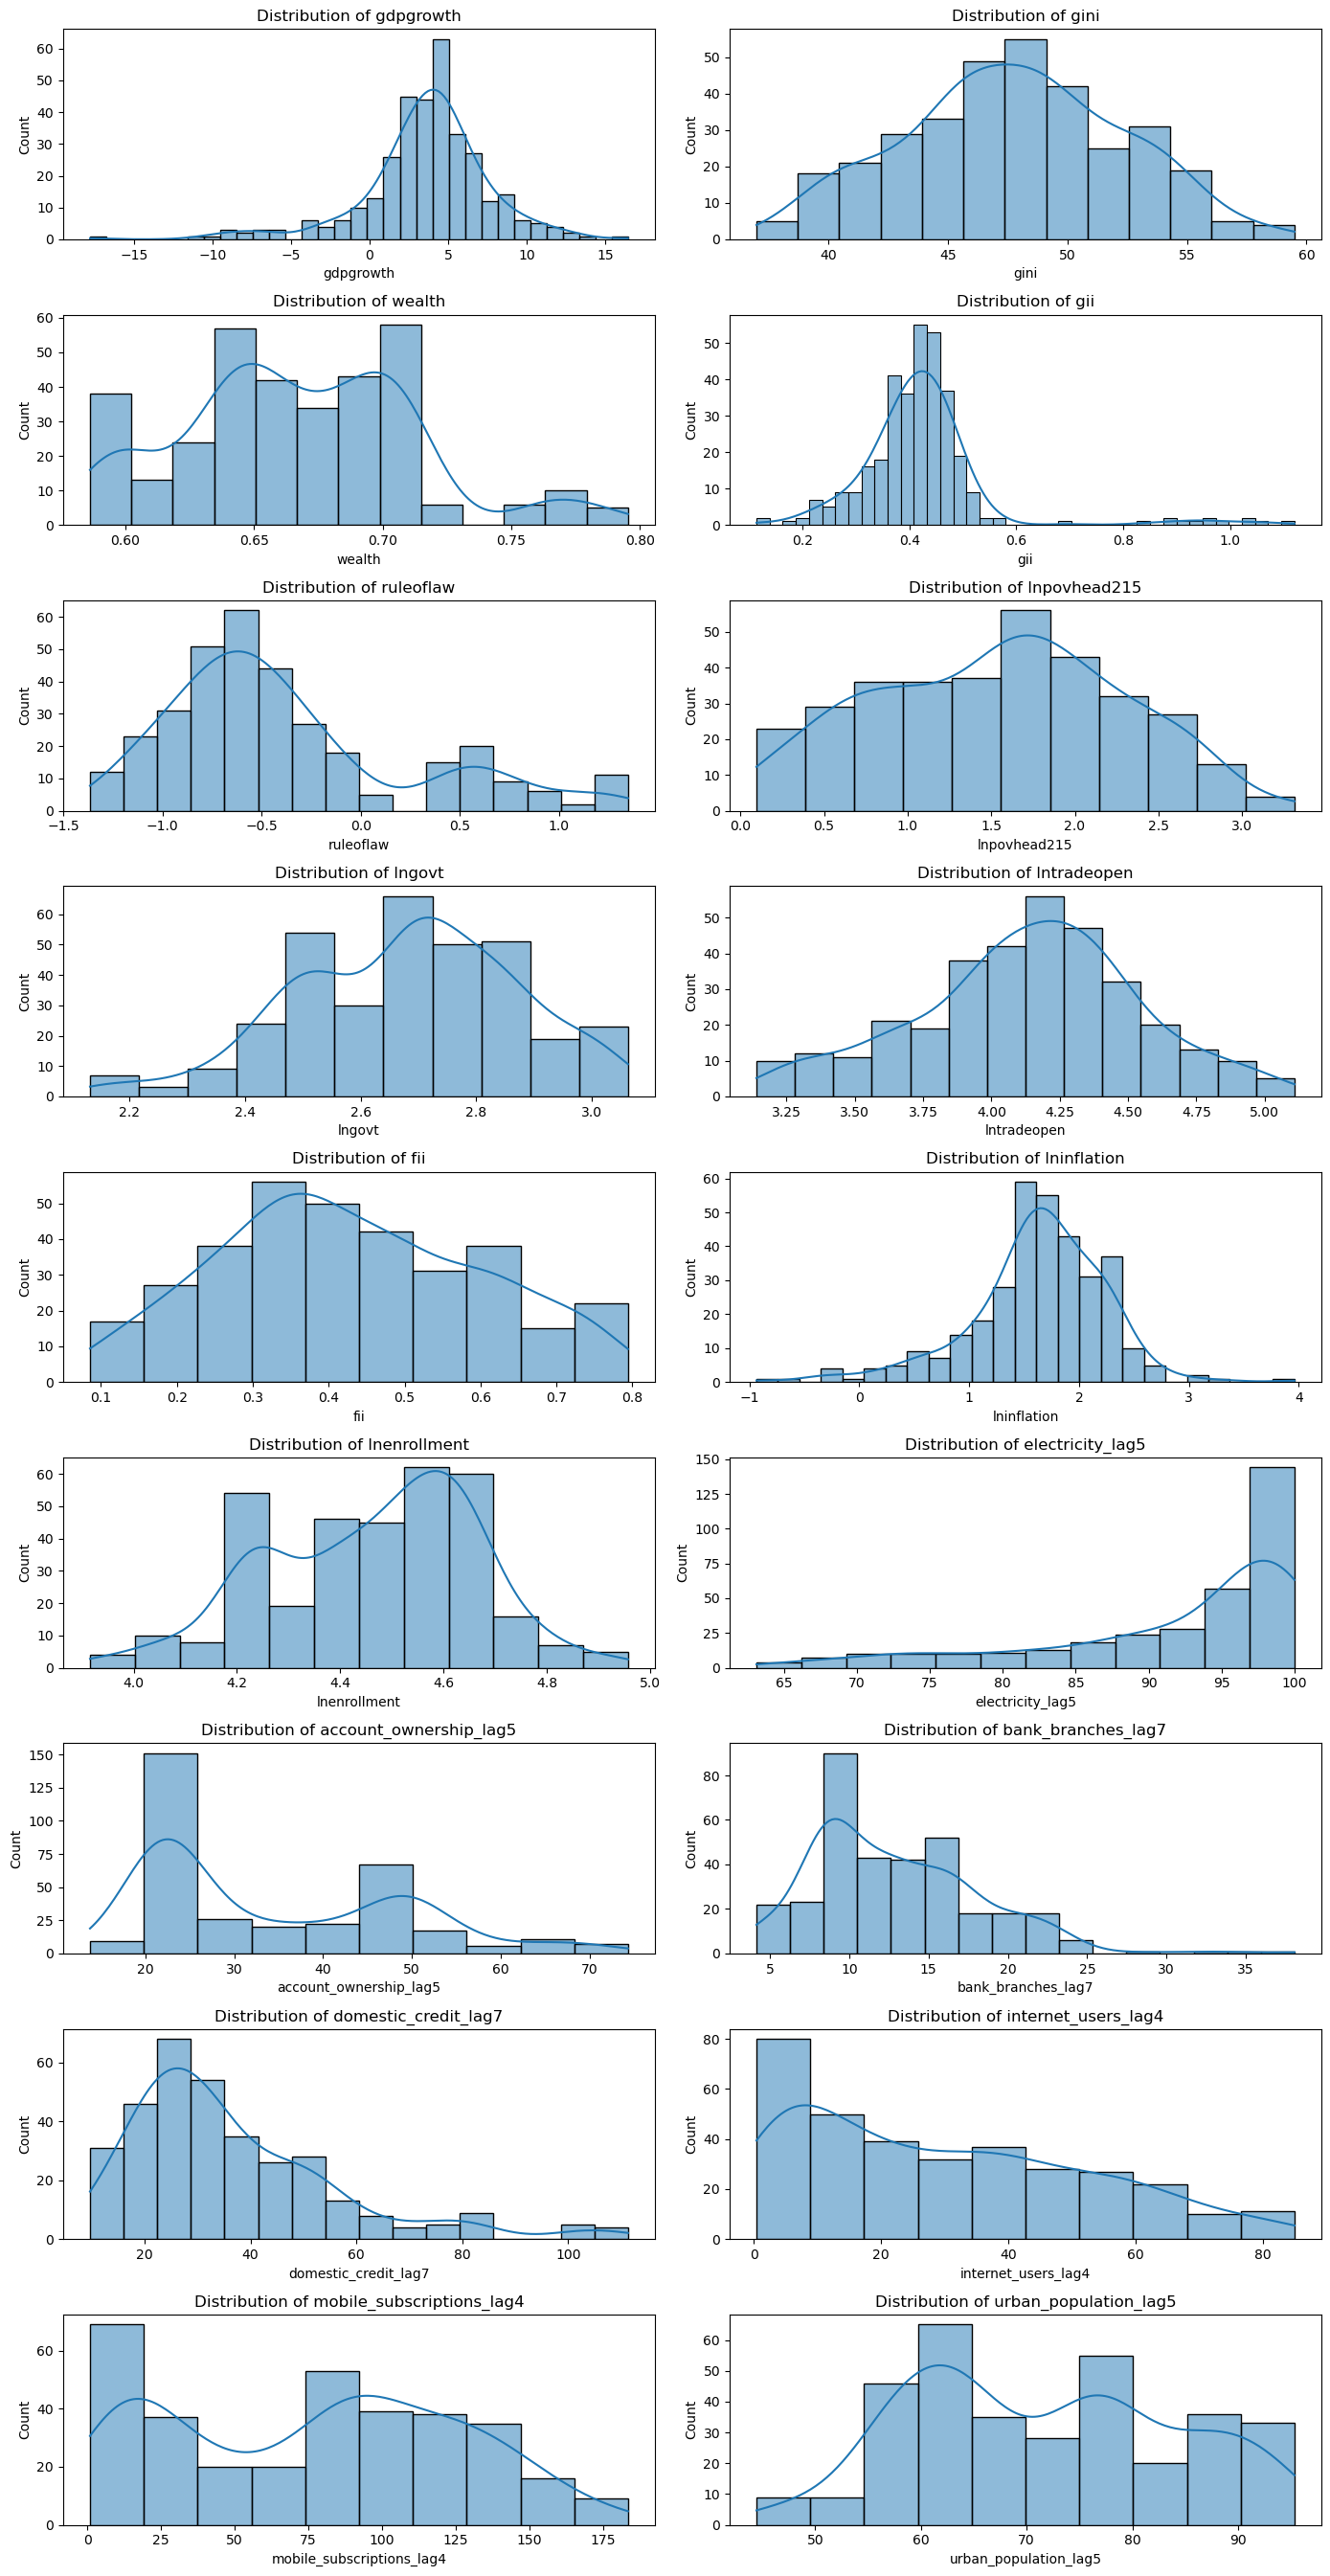

In [27]:
import numpy as np

panel_df = build_panel()
# Select numeric columns excluding 'Year'
numeric_cols = panel_df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != 'Year']

# Create subplots
fig, axes = plt.subplots(nrows=len(numeric_cols)//2 + len(numeric_cols)%2, ncols=2, figsize=(14, 3*len(numeric_cols)//2))
axes = axes.flatten()

# Plot histograms for each numeric column
for i, col in enumerate(numeric_cols):
    sns.histplot(panel_df[col].dropna(), kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

# Adjust layout and save the figure
plt.tight_layout()
# No need to save the figure, just display it
plt.show()


Normal distributions: Seen in gdpgrowth, gini, Intraideopen, and Inflation (slight skew).

Non-normal/multimodal: wealth, gii, ruleoflaw suggest subgroups.

Right-skewed: electricity_lag5, account_ownership_lag5, bank_branches_lag7, and others indicate concentration at low values.

Outliers present: Especially in electricity_lag5 and account_ownership_lag5.


## 2  Descriptive analysis

In [28]:

# Country‑level summary stats
country_stats = (panel_df
                 .groupby('Country')
                 .agg({'lnpovhead215':['mean','std'],
                       'fii':['mean','std'],
                       'gini':['mean','std'],
                       'gii':['mean','std']}))
country_stats.head()


lnpovhead215                 fii                 gini            \
                  mean       std      mean       std       mean       std   
Country                                                                     
Argentina     0.795043  0.399624  0.467776  0.135694  43.654762  2.831338   
Bolivia       1.863419  0.524018  0.295755  0.121195  47.735714  5.484960   
Brazil        1.868325  0.370012  0.654839  0.121551  53.557143  1.901729   
Chile         0.761537  0.441394  0.636106  0.082827  46.707143  2.016237   
Colombia      2.128971  0.311543  0.480869  0.120689  53.252381  1.744438   

                gii            
               mean       std  
Country                        
Argentina  0.358810  0.087826  
Bolivia    0.453152  0.117396  
Brazil     0.463238  0.116593  
Chile      0.296952  0.088412  
Colombia   0.473095  0.120932

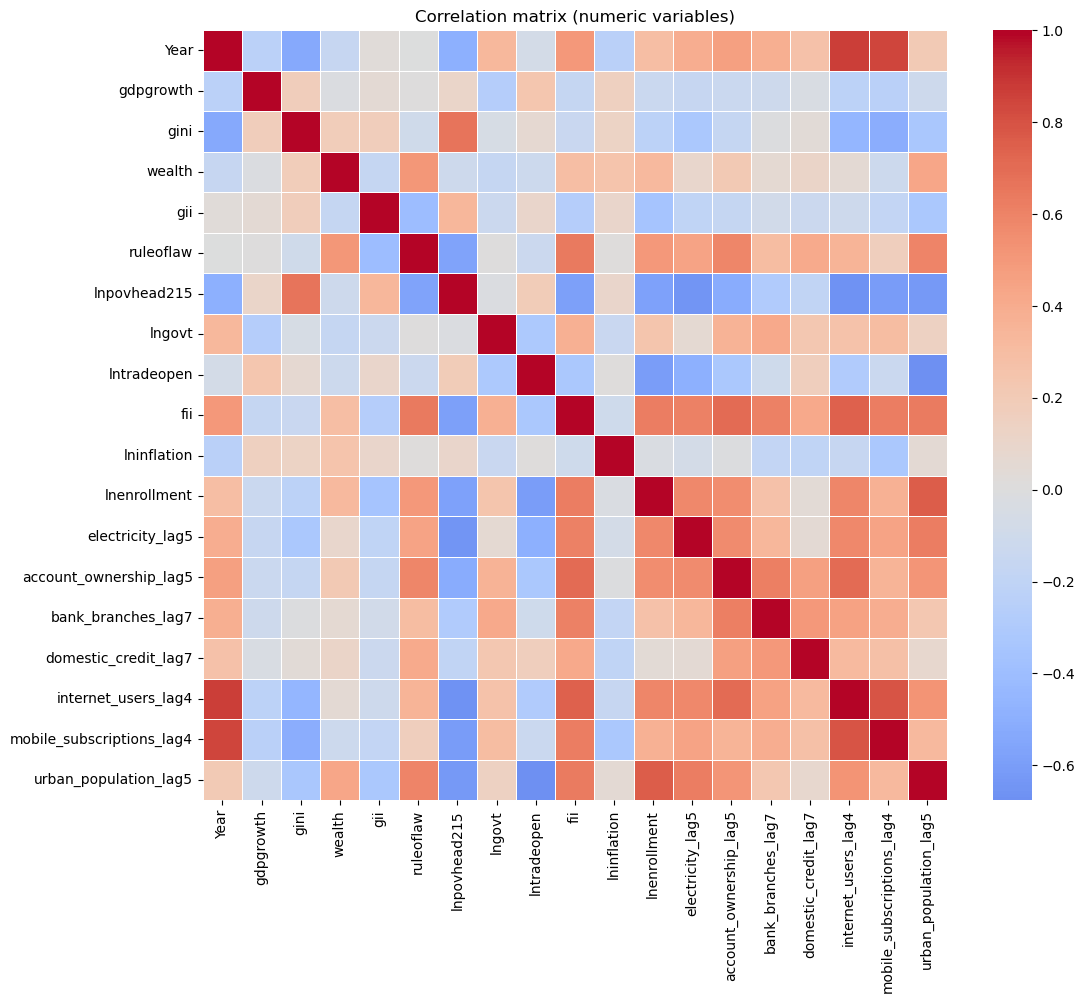

In [29]:

# Correlation heatmap (numeric variables)
numeric_cols = panel_df.select_dtypes(include='number').columns
corr = panel_df[numeric_cols].corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='coolwarm', center=0, linewidths=.5)
plt.title('Correlation matrix (numeric variables)')
plt.show()


Strong Positive: Ingovt-ruleoflaw (0.7+), lnenrollment-wealth (0.7+), domestic_credit-mobile_subscriptions (0.7+).

Strong Negative: gini-wealth (-0.6), Inflation-ruleoflaw (-0.6).

## 3  Econometric models

### 3.1 Fixed‑effects baseline

In [33]:
project_root = Path.cwd() / "functions"
from functions.panel_models import run_fe  # Import the run_fe function

panel_mi = panel_df.set_index(['Country','Year'])
res_fe = run_fe(panel_mi, y='lnpovhead215')


Fixed Effects Model Results (Dependent Variable: lnpovhead215)
                          PanelOLS Estimation Summary                           
Dep. Variable:           lnpovhead215   R-squared:                        0.0355
Estimator:                   PanelOLS   R-squared (Between):              0.1421
No. Observations:                 336   R-squared (Within):               0.0903
Date:                Sat, May 10 2025   R-squared (Overall):              0.1241
Time:                        01:36:31   Log-likelihood                    57.015
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      3.6470
Entities:                          16   P-value                           0.0131
Avg Obs:                       21.000   Distribution:                   F(3,297)
Min Obs:                       21.000                                           
Max Obs:                       21.000   F-stat

### Conclusion from Fixed Effects Model Results

1. **Model Fit**:
    - Overall R-squared: 0.1241 (12.41% variation explained).
    - Within R-squared: 0.0903 (9.03% variation within entities over time).

2. **Significance of Variables**:
    - None of the independent variables (`lngovt`, `lntradeopen`, `ruleoflaw`) are statistically significant (p-values > 0.05).
    - Constant term is also not significant (p-value = 0.3191).

3. **F-Test for Poolability**:
    - P-value = 0.0000, confirming the fixed effects model is appropriate.

4. **Coefficients**:
    - `lngovt`: Coefficient = -0.2738, not significant.
    - `lntradeopen`: Coefficient = 0.1306, not significant.
    - `ruleoflaw`: Coefficient = -0.1279, not significant.

5. **Conclusion**:
    - No strong evidence of significant relationships between independent variables and `lnpovhead215`.
    - Further analysis with additional variables or alternative models is recommended.


### 3.2 IV fixed‑effects

In [34]:
from functions.panel_models import run_iv_fe  # Import the run_iv_fe function

# Specify the instruments explicitly
instruments = ['account_ownership_lag5', 'bank_branches_lag7', 'domestic_credit_lag7']

# Run the IV fixed-effects model
res_iv = run_iv_fe(panel_mi, y='lnpovhead215', instruments=instruments)


IV2SLS FE‐IV Model Results (lnpovhead215)
                          IV-2SLS Estimation Summary                          
Dep. Variable:           lnpovhead215   R-squared:                      0.9238
Estimator:                    IV-2SLS   Adj. R-squared:                 0.9138
No. Observations:                 336   F-statistic:                -2.554e+16
Date:                Sat, May 10 2025   P-value (F-stat)                1.0000
Time:                        01:37:49   Distribution:                F(39,296)
Cov. Estimator:             clustered                                         
                                                                              
                                        Parameter Estimates                                         
                                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------------------------
Intercept              

### IV2SLS FE-IV Model Results (lnpovhead215) - Conclusions

1. **Model Fit**:
    - R-squared: 0.9238, Adjusted R-squared: 0.9138.
    - F-statistic: -2.554e+16 (numerical issues).

2. **Significance**:
    - Key variables (`lngovt`, `lntradeopen`, `ruleoflaw`, `fii`) are not significant (p > 0.05).
    - Significant country effects: Honduras (p = 0.0074), Uruguay (p = 0.0116).
    - Year effect: 2004 (p = 0.0440).

3. **Coefficients**:
    - `lngovt`: -0.2684, `lntradeopen`: 0.1679, `ruleoflaw`: -0.0571, `fii`: -0.9900 (all not significant).

4. **Instruments**:
    - Used: `account_ownership_lag5`, `bank_branches_lag7`, `domestic_credit_lag7`.
    - No strong endogeneity correction (`fii` insignificant).

5. **Conclusion**:
    - High R-squared but key variables lack significance.
    - Country heterogeneity evident; refine instruments or add variables.


### 3.3 Interaction model – FI × Gender Inequality Index

In [35]:

from functions.panel_models import run_interaction  # Import the run_interaction function

res_inter = run_interaction(panel_mi.reset_index(), modifier='gini', y='lnpovhead215')


Interaction Model Results (Dependent Variable: lnpovhead215, Modifier: gini)
                          PanelOLS Estimation Summary                           
Dep. Variable:           lnpovhead215   R-squared:                        0.2907
Estimator:                   PanelOLS   R-squared (Between):              0.1358
No. Observations:                 336   R-squared (Within):               0.6512
Date:                Sat, May 10 2025   R-squared (Overall):              0.1698
Time:                        01:38:53   Log-likelihood                    108.64
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      20.082
Entities:                          16   P-value                           0.0000
Avg Obs:                       21.000   Distribution:                   F(6,294)
Min Obs:                       21.000                                           
Max Obs:                       2

### Conclusions from Interaction Model Results (Dependent Variable: lnpovhead215, Modifier: gini)

1. **Model Fit**:
    - Within R-squared: 65.12%, Overall R-squared: 16.98%.
    - F-statistic: 6.39 (P-value = 0.0000).

2. **Significant Variables**:
    - `gini`: Positive effect (P-value = 0.0190, Coefficient = 0.0688).
    - `fii` and `fii_gini`: Not significant.

3. **Other Variables**:
    - `lngovt`, `lntradeopen`, `ruleoflaw`: Not significant.

4. **Conclusion**:
    - Inequality (`gini`) impacts poverty, but no moderating effect of `fii` financial inclusion index.
    - Further exploration of modifiers is needed.

5. **Visualization**:
    - Marginal effects plot saved: `reports/figures/marginal_effect_fii_gini_lnpovhead215.png`.


### 3.4 Interaction model – FI × Gender Inequality Index

In [36]:

res_inter = run_interaction(panel_mi.reset_index(), modifier='gii', y='lnpovhead215')


Interaction Model Results (Dependent Variable: lnpovhead215, Modifier: gii)
                          PanelOLS Estimation Summary                           
Dep. Variable:           lnpovhead215   R-squared:                        0.0917
Estimator:                   PanelOLS   R-squared (Between):              0.0435
No. Observations:                 336   R-squared (Within):               0.1962
Date:                Sat, May 10 2025   R-squared (Overall):              0.0536
Time:                        01:40:18   Log-likelihood                    67.091
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      4.9454
Entities:                          16   P-value                           0.0001
Avg Obs:                       21.000   Distribution:                   F(6,294)
Min Obs:                       21.000                                           
Max Obs:                       21

### Conclusions from Interaction Model Results (Dependent Variable: lnpovhead215, Modifier: gii)

1. **Model Fit**:
    - Within R-squared: 19.62%, Overall R-squared: 5.36%.
    - F-statistic: 4.9454 (P-value = 0.0001).

2. **Significant Variables**:
    - Interaction term (`fii_gii`): Marginally significant (P-value = 0.0577, Coefficient = -2.1754).
    - `fii` and `gii`: Not significant.

3. **Other Variables**:
    - `lngovt`, `lntradeopen`, `ruleoflaw`: Not significant.

4. **Conclusion**:
    - Interaction between financial inclusion (`fii`) and gender inequality index (`gii`) shows a marginally significant negative effect on poverty.
    - Further exploration of interaction effects is recommended.

5. **Visualization**:
    - Marginal effects plot saved: `reports/figures/marginal_effect_fii_gii_lnpovhead215.png`.

### 3.5 Interaction model – FI × Enrollment

In [37]:
res_inter = run_interaction(panel_mi.reset_index(), modifier='lnenrollment', y='lnpovhead215')

Interaction Model Results (Dependent Variable: lnpovhead215, Modifier: lnenrollment)
                          PanelOLS Estimation Summary                           
Dep. Variable:           lnpovhead215   R-squared:                        0.2547
Estimator:                   PanelOLS   R-squared (Between):             -37.165
No. Observations:                 336   R-squared (Within):               0.3648
Date:                Sat, May 10 2025   R-squared (Overall):             -34.686
Time:                        01:41:30   Log-likelihood                    100.32
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      16.744
Entities:                          16   P-value                           0.0000
Avg Obs:                       21.000   Distribution:                   F(6,294)
Min Obs:                       21.000                                           
Max Obs:                

### Conclusions from Interaction Model Results (Dependent Variable: lnpovhead215, Modifier: lnenrollment)

1. **Model Fit**:
    - Within R-squared: 36.48%, Overall R-squared: -34.69%.
    - F-statistic: 16.744 (P-value = 0.0000).

2. **Significant Variables**:
    - `fii`: Strong negative effect (P-value = 0.0000).
    - `lnenrollment`: Negative effect (P-value = 0.0000).
    - Interaction term (`fii_lnenrollment`): Positive effect (P-value = 0.0000).

3. **Other Variables**:
    - `lngovt`, `lntradeopen`, `ruleoflaw`: Not significant.

4. **Conclusion**:
    - Financial inclusion (`fii`) and enrollment (`lnenrollment`) have opposing effects on poverty.
    - Interaction term suggests that the negative impact of `fii` is mitigated by higher enrollment levels.

5. **Visualization**:
    - Marginal effects plot saved: `reports/figures/marginal_effect_fii_lnenrollment_lnpovhead215.png`.


### 3.6 Time‑trend augmented model

In [38]:

from functions.panel_models import run_fe_trend  # Import the run_fe_trend function

res_trend = run_fe_trend(panel_mi, y='lnpovhead215')


Fixed Effects with Time Trend Model Results (Dependent Variable: lnpovhead215)
                          PanelOLS Estimation Summary                           
Dep. Variable:           lnpovhead215   R-squared:                        0.7780
Estimator:                   PanelOLS   R-squared (Between):             -0.8709
No. Observations:                 336   R-squared (Within):               0.7780
Date:                Sat, May 10 2025   R-squared (Overall):             -0.7620
Time:                        01:42:11   Log-likelihood                    53.000
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      183.43
Entities:                          16   P-value                           0.0000
Avg Obs:                       21.000   Distribution:                   F(6,314)
Min Obs:                       21.000                                           
Max Obs:                      

### Conclusions from Fixed Effects with Time Trend Model Results (Dependent Variable: lnpovhead215)

1. **Model Fit**:
    - Within R-squared: 77.80% (strong fit within entities).
    - Overall R-squared: -76.20% (poor explanatory power overall).
    - F-statistic: 183.43 (P-value = 0.0000, model significant).

2. **Significant Variables**:
    - `fii`: Strong negative effect on poverty (P-value = 0.0000, Coefficient = -1.9724).
    - `trend`: Negative time trend (P-value = 0.0000, Coefficient = -0.0871).
    - `fii_trend`: Positive interaction (P-value = 0.0001, Coefficient = 0.1008).

3. **Other Variables**:
    - `lngovt`, `lntradeopen`, `ruleoflaw`: Not significant.

4. **Conclusion**:
    - Financial inclusion (`fii`) reduces poverty, but its effect weakens over time (`fii_trend`).
    - Poverty decreases over time (`trend`).
    - Further analysis of time-varying effects is recommended.


## 4  Conclusion

This project provided a comprehensive analysis of the relationship between poverty and various socio-economic factors using panel data econometric models. Key findings include:

1. **Fixed Effects Model**:
    - No significant relationship was found between poverty and the independent variables (`lngovt`, `lntradeopen`, `ruleoflaw`).
    - The model explained only 9.03% of the within-entity variation, suggesting limited explanatory power.

2. **IV Fixed Effects Model**:
    - Despite a high R-squared value (92.38%), key variables lacked statistical significance.
    - Country-specific effects were evident, with Honduras and Uruguay showing significant coefficients.
    - The instruments used (`account_ownership_lag5`, `bank_branches_lag7`, `domestic_credit_lag7`) did not strongly address endogeneity.

3. **Interaction Models**:
    - Interaction between financial inclusion (`fii`) and enrollment (`lnenrollment`) revealed a mitigating effect of higher enrollment on poverty.
    - Gender inequality (`gii`) showed a marginally significant interaction with financial inclusion, indicating nuanced effects on poverty.
    - Other modifiers like `gini` and time trends highlighted the complexity of poverty dynamics.

4. **Time-Trend Augmented Model**:
    - Financial inclusion (`fii`) significantly reduced poverty, but its effect weakened over time.
    - A negative time trend indicated overall poverty reduction over the years.

### Recommendations:
- **Policy Implications**:
  - Enhance financial inclusion and education to mitigate poverty effectively.
  - Address country-specific heterogeneity by tailoring policies to local contexts.

- **Future Research**:
  - Explore additional instruments to address endogeneity more robustly.
  - Investigate non-linear relationships and other interaction effects.
  - Incorporate more granular data to capture regional variations.

This analysis underscores the importance of multi-faceted approaches to poverty alleviation, combining financial, educational, and institutional reforms.